Source: https://qiskit.org/textbook/ch-algorithms/shor.html

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint

from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

from math import gcd
from fractions import Fraction

We provide the circuits for U where:

U|y> = |ay mod 15>

The function c_amod15 returns the controlled-U gate for a, repeated power times

In [2]:
def c_amod15(a, power):
    #controlled multiplication by a mod 15
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2, 7, 8, 11, or 13")
    
    U = QuantumCircuit(4)
    
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    
    return c_U

In [3]:
#use 8 counting qubits
n_count = 8
a = 7

In [5]:
#import the circuit for QFT
def qft_dagger(n):
    qc = QuantumCircuit(n)
    
    for qubit in range(n//2):
        qc.swap(qubit, n - qubit - 1)
    
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2 ** (j-m)), m, j)
        qc.h(j)
    qc.name = 'QFT-dagger'
    
    return qc

With these building blocks in place we can construct the circuit for Shor's algorithm.

In [13]:
#create quantum circuit with n_count counting qubits
#plus 4 qubits for U to act on

qc = QuantumCircuit(n_count + 4, n_count)

#initialize counting qubits in state |+>
#and auxiliary in state |1>
for q in range(n_count):
    qc.h(q)

qc.x(3 + n_count)

#controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])
    
#inverse QFT
qc.append(qft_dagger(n_count), range(n_count))

#measure circuit
qc.measure(range(n_count), range(n_count))

qc.draw(fold=-1)

┌───┐                                                                                                                             ┌─────────────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0            ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │             │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1            ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │             │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2            ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │             │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3            ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT-dagger │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4            ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │             │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5            ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │             │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6            ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │             │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7            ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└─────────────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├────────────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │                ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├────────────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 ││  7^8 mod 15 ││  7^16 mod 15 ││  7^32 mod 15 ││  7^64 mod 15 ││  7^128 mod 15 │                ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├────────────────╫──╫──╫──╫──╫──╫──╫──╫─
      ┌───┐│             ││             ││             ││             ││              ││              ││              ││              

#### Engage the simulator

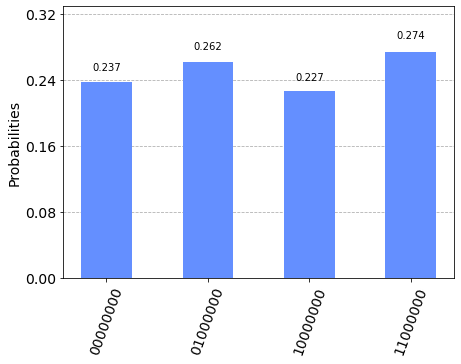

In [15]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)

qobj = assemble(t_qc)

results = aer_sim.run(qobj).result()
counts = results.get_counts()

plot_histogram(counts)

Since we have 3 qubits, the results correspond to certain measured phases:

In [18]:
rows, measured_phases = [], []

for output in counts:
    decimal = int(output,2) #convert base 2 into decimal
    phase = decimal / (2**n_count) #find corresponding eigenvalue
    measured_phases.append(phase)
    
    rows.append([f"{output} (binary) = {decimal:>3} (decimal)",
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
    
headers = ["Register Output","Phase"]

df = pd.DataFrame(rows, columns=headers)

print(df)

                     Register Output           Phase
0  11000000 (binary) = 192 (decimal)  192/256 = 0.75
1  00000000 (binary) =   0 (decimal)    0/256 = 0.00
2  01000000 (binary) =  64 (decimal)   64/256 = 0.25
3  10000000 (binary) = 128 (decimal)  128/256 = 0.50


We'll used *continued fractions* to find s and r. We can use the built-in **fractions** module to turn a float into a Fraction object, for example:

In [24]:
Fraction(0.66)

Fraction(5944751508129055, 9007199254740992)

In [25]:
Fraction(0.66).limit_denominator(15)

Fraction(2, 3)

In [27]:
rows = []

for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}",frac.denominator])
    
#print as a table
headers = ['Phase', 'Fraction', 'Guess for r']
df = pd.DataFrame(rows, columns = headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.00      0/1            1
2   0.25      1/4            4
3   0.50      1/2            2


#### Modular Exponentiation

Classical computers can use an algorithm known as *repeated squaring* to calculate an exponential. Since we are dealing with exponentials of the form 2^j, the repeated algorithm is simple:

In [28]:
def a2jmodN(a, j, N):
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [29]:
a2jmodN(7, 2049, 53)

47

#### Factoring from Period Finding

In [30]:
#example with N = 15
N = 15

In [31]:
#first choose a random number a between 1 and N-1
np.random.seed(1)
a = randint(2, 15)
print(a)

7


In [32]:
#check that it isn't already a non-trivial factor of N
from math import gcd

gcd(a,N)

1

Next we do Shor's order finding algorithm for a = 7 and N = 15. That phase we measure will be s/r where:

a^r mod N = 1

and s is a random integer between 0 and r-1

In [44]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    
    #initialize counting qubits in state |+> and auxiliary in state |1>
    for q in range(n_count):
        qc.h(q)
    qc.x(3 + n_count)
    
    #controlled-U operations
    for q in range(n_count):
        qc.append(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])
    
    #inverse QFT and measure
    qc.append(qft_dagger(n_count), range(n_count))
    qc.measure(range(n_count), range(n_count))
    
    #simulate results
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    
    #setting memory = True lets us see a list of each sequential reading
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    
    phase = int(readings[0],2) / (2**n_count)
    
    print(f"Register reading: {readings[0]}")
    print(f"Corresponding phase: {phase}")
    
    return phase

In [45]:
#now we can find a guess for r
phase = qpe_amod15(a)
Fraction(phase).limit_denominator(15)

Register reading: 10000000
Corresponding phase: 0.5


Fraction(1, 2)

In [46]:
frac = Fraction(phase).limit_denominator(15)

s, r = frac.numerator, frac.denominator

print(r)

2


In [47]:
guesses = [gcd(a**(r//2)-1,N), gcd(a**(r//2)+1,N)]

print(guesses)

[3, 1]


In [50]:
#this cell repeates the algorithm until at least one factor of 15 is found
a = 7
factor_found = False
attempt = 0

while not factor_found:
    attempt +=1
    print(f"Attempt: {attempt}")
    
    phase = qpe_amod15(a)
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    
    if phase !=0:
        guesses = [gcd(a**(r//2)-1,N), gcd(a**(r//2)+1,N)]
        print(f"Guessed factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                print(f"******Non-trivial factor found: {guess} ******")
                factor_found = True

Attempt: 1
Register reading: 11000000
Corresponding phase: 0.75
Result: r = 4
Guessed factors: 3 and 5
******Non-trivial factor found: 3 ******
******Non-trivial factor found: 5 ******
